# LOF Presentation

In [1]:
import pandas as pd
import numpy as np
#basics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
#plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Get list of column names in excel style
def get_excel_columns(n_cols):
    col_list = []
    n = n_cols
    alpha_list = [chr(c) for c in range(ord('A'), ord('Z') + 1)]
    alpha_list.insert(0,'dummy')
    for i in range(1,n+1):
        col_i = ""
        index_list=[]
        p=[]
        while i>26:
            k = i%26
            i = i//26
            if k==0:
                index_list.append(26)
                i = i-1
            else:
                index_list.append(k)
        index_list.append(int(i))
        index_list.reverse()
        for i in index_list:
            p.append(alpha_list[i])
            col_i = "".join(p)
        col_list.append(col_i)
    return col_list

In [3]:
df = pd.read_csv("shuttle.csv")
df.columns = get_excel_columns(len(df.columns))
df

,A,B,C,D,E,F,G,H,I,J
0,81.0,0.0,84.0,0.0,-14.0,-2.0,4.0,100.0,96.0,o
1,81.0,0.0,84.0,0.0,-20.0,16.0,4.0,105.0,102.0,o
2,76.0,-1.0,81.0,0.0,-42.0,-3.0,5.0,125.0,120.0,o
3,105.0,0.0,107.0,2.0,70.0,0.0,1.0,37.0,36.0,o
4,79.0,0.0,83.0,-1.0,-40.0,7.0,4.0,124.0,120.0,o
...,...,...,...,...,...,...,...,...,...,...
46458,46.0,5.0,78.0,0.0,46.0,5.0,32.0,32.0,0.0,n
46459,37.0,0.0,79.0,-1.0,10.0,3.0,43.0,69.0,26.0,n
46460,48.0,0.0,78.0,3.0,46.0,0.0,30.0,32.0,2.0,n
46461,41.0,0.0,79.0,0.0,38.0,-25.0,38.0,40.0,2.0,n


In [4]:
X = df.iloc[:, 0:-1].values.astype(float)
X = StandardScaler().fit(X).transform(X.astype(float))
X

array([[ 4.14081579e+00,  1.61153480e-02, -9.54804752e-02, ...,
        -3.28877769e+00,  3.15611632e+00,  5.97795978e+00],
       [ 4.14081579e+00,  1.61153480e-02, -9.54804752e-02, ...,
        -3.28877769e+00,  3.44933016e+00,  6.37781996e+00],
       [ 3.56928848e+00, -6.49987487e-03, -4.39105168e-01, ...,
        -3.19760301e+00,  4.62218551e+00,  7.57740051e+00],
       ...,
       [ 3.68735550e-01,  1.61153480e-02, -7.82729860e-01, ...,
        -9.18236110e-01, -8.31591881e-01, -2.86516406e-01],
       [-4.31402684e-01,  1.61153480e-02, -6.68188296e-01, ...,
        -1.88838702e-01, -3.62449739e-01, -2.86516406e-01],
       [-5.45708145e-01, -5.17303206e-02,  1.73718455e+00, ...,
         1.90817885e+00,  9.27691150e-01, -2.86516406e-01]])

In [5]:
y = df.iloc[:, -1]
y

0        o
1        o
2        o
3        o
4        o
        ..
46458    n
46459    n
46460    n
46461    n
46462    n
Name: J, Length: 46463, dtype: object

In [6]:
y = LabelEncoder().fit_transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)

Train Data:  (32524, 9) (32524,)
Test Data:  (13939, 9) (13939,)


In [8]:
def apply_LOF(X, y, low=1, high=50):
    y1 = np.where(y == 1, -1, 1)
    accuracy = []
    for i in range(low, high+1):
        clf = LocalOutlierFactor(n_neighbors = i, contamination = 'auto')
        y_pred = clf.fit_predict(X)
        accuracy.append(metrics.accuracy_score(y1, y_pred))
    plt.figure(figsize = (10, 6))
    sns.lineplot(range(low, high+1), accuracy)
        

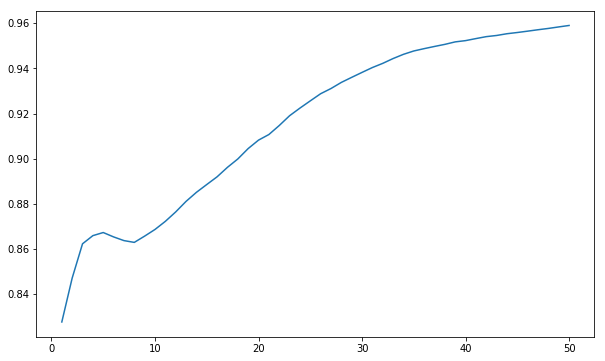

In [9]:
apply_LOF(X, y)

In [9]:
def apply_LOF_novelty(X_train, X_test, y_train, y_test, low = 1, high = 50):
    y_test_enc = np.where(y_test == 1, -1, 1)
    y_train_list = []
    for i in y_train:
        y_train_list.append(i)
    j=0
    X_train_list = []
    for i in X_train:
        m = []
        m = i.tolist()
        m.append(y_train_list[j])
        X_train_list.append(m)
        j = j+1
    df_rejoined = pd.DataFrame(X_train_list)
    # df_rejoined[30].value_counts()
    df_rejoined_inliers = df_rejoined.loc[df_rejoined.iloc[:,-1] == 0]
#     df_rejoined_inliers
#     X_train_inliers = df_rejoined_inliers.iloc[:, 0:-1].to_numpy()
    X_train_inliers = df_rejoined_inliers.iloc[:, 0:-1].values.astype(float)
#     X_train_inliers

    accuracy1 = []
    for i in range(low, high + 1):
        clf = LocalOutlierFactor(n_neighbors = i, novelty = True, contamination = 'auto')
        clf.fit(X_train_inliers)
        y_pred = clf.predict(X_test)
        accuracy1.append(metrics.accuracy_score(y_test_enc, y_pred))
    plt.figure(figsize = (10, 6))
    sns.lineplot(range(low, high+1), accuracy1)

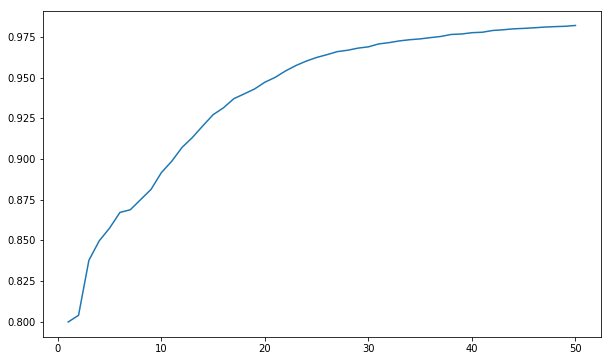

In [9]:
apply_LOF_novelty(X_train, X_test, y_train, y_test)

In [10]:
def roc_lof_novelty(X_train, X_test, y_train, y_test, neighbors = 20, cont = 0.000000000001):
    y_test_roc = np.where(y_test == 1, -1, 1)
    y_train_list_roc = []
    for i in y_train:
        y_train_list_roc.append(i)
    j=0
    X_train_list_roc = []
    for i in X_train:
        m = []
        m = i.tolist()
        m.append(y_train_list_roc[j])
        X_train_list_roc.append(m)
        j = j+1
    df_rejoined_roc = pd.DataFrame(X_train_list_roc)
#     # df_rejoined[30].value_counts()
    df_rejoined_inliers_roc = df_rejoined_roc.loc[df_rejoined_roc.iloc[:,-1] == 0]
# #     df_rejoined_inliers
# #     X_train_inliers = df_rejoined_inliers.iloc[:, 0:-1].to_numpy()
    X_train_inliers_roc = df_rejoined_inliers_roc.iloc[:, 0:-1].values.astype(float)
# #     X_train_inliers
    clf = LocalOutlierFactor(n_neighbors = neighbors, novelty = True, contamination = cont)
    clf.fit(X_train_inliers_roc)
#     clf.fit(X_train)
    y_proba = clf.decision_function(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test_roc, y_proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure(figsize = (10,10))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of LOF')
    plt.show()
    


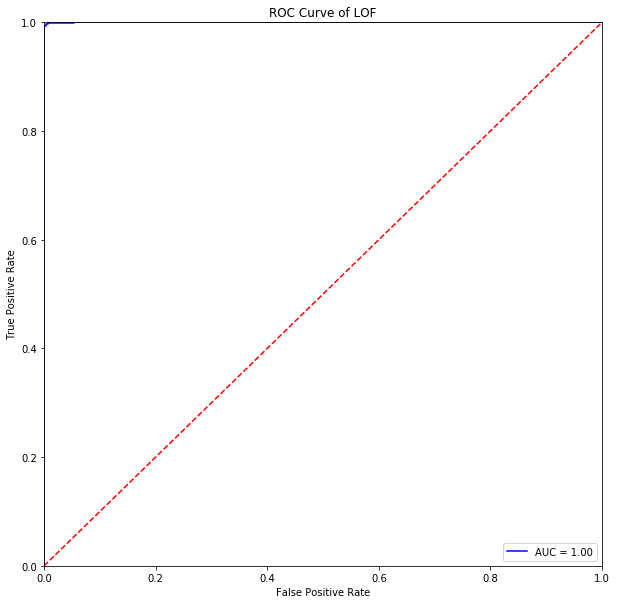

In [15]:
roc_lof_novelty(X_train, X_test, y_train, y_test)

In [11]:
def roc_lof(X, y, neighbors = 20, cont = 'auto'):
    y_test_roc1 = np.where(y == 1, -1, 1)
    clf = LocalOutlierFactor(n_neighbors = neighbors,contamination = cont)
    clf.fit(X)
#     y_proba = clf.decision_function(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test_roc1, -clf.negative_outlier_factor_)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure(figsize = (10,10))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of LOF')
    plt.show()
    


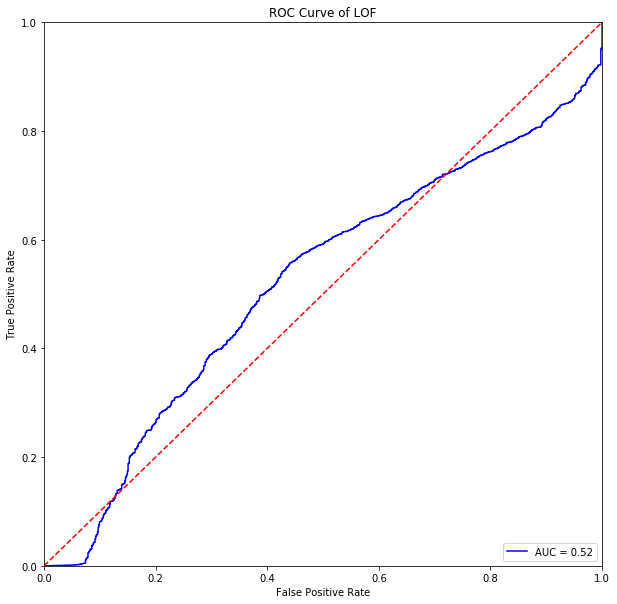

In [77]:
roc_lof(X, y)

In [12]:
def apply_KNN(X_train, X_test, y_train, y_test, low = 1, high = 30):
#     X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
#     X = StandardScaler().fit(X).transform(X.astype(float))
#     y = df.iloc[:, -1]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = randomState)
    accuracy = []
    error_rate = []
    for i in range(low, high+1):
        KNN = KNeighborsClassifier(n_neighbors = i)
        KNN.fit(X_train, y_train)
        y_hat = KNN.predict(X_test)
        n_errors = np.count_nonzero(y_hat != y_test)
        accuracy.append((len(y_test)-n_errors)/len(y_test)*100)
        error_rate.append(np.mean(y_hat != y_test))
    sns.lineplot(range(low, high+1), accuracy)

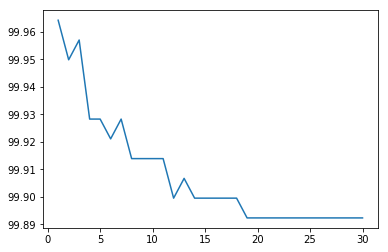

In [54]:
apply_KNN(X_train, X_test, y_train, y_test)

In [13]:
def roc_KNN(X_train, X_test, y_train, y_test, k = 20):
#     X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
#     X = StandardScaler().fit(X).transform(X.astype(float))
#     y = df.iloc[:, -1]
#     y = LabelEncoder().fit_transform(y)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = randomState)
#     encoder = LabelEncoder()
#     y_train = encoder.fit_transform(y_train)
#     y_test = encoder.fit_transform(y_test)
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    y_pred = KNN.predict(X_)
    #get probability scores
    y_scores = KNN.predict_proba(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_scores[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    #plot
    plt.figure(figsize = (10,10))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of kNN')
    plt.show()

[0 0 0 ... 0 0 0]


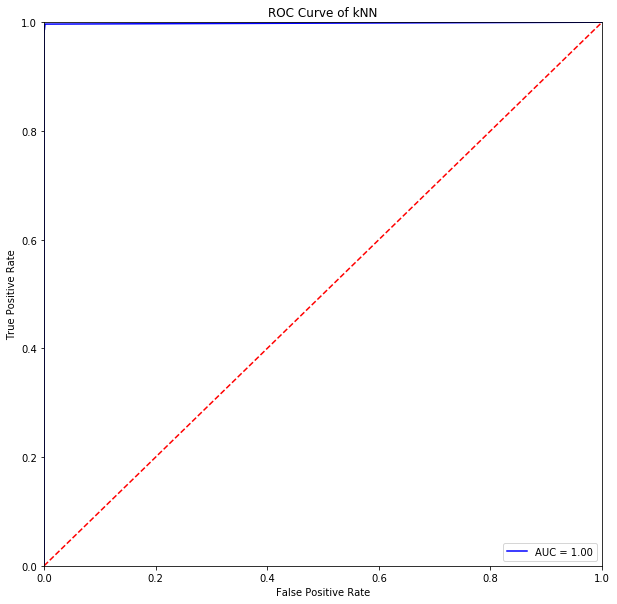

In [61]:
roc_KNN(X_train, X_test, y_train, y_test)

In [14]:
def apply_HBOS(X_train, X_test, y_train, y_test, low = 1, high = 50):
    accuracy = []
    for i in range(low, high + 1):
        clf = HBOS(n_bins = i)
        clf.fit(X_train)
        y_hat = clf.predict(X_test)
        n_errors = np.count_nonzero(y_hat != y_test)
        accuracy.append((len(y_test)-n_errors)/len(y_test)*100)
        
        
        
        
    plt.figure(figsize = (10, 10))
    plt.xlabel('n_bins')
    plt.ylabel('Accuracy %')
    plt.title ('Accuracy v/s n_bins - HBOS')
    plt.plot(range(low, high+1), accuracy)

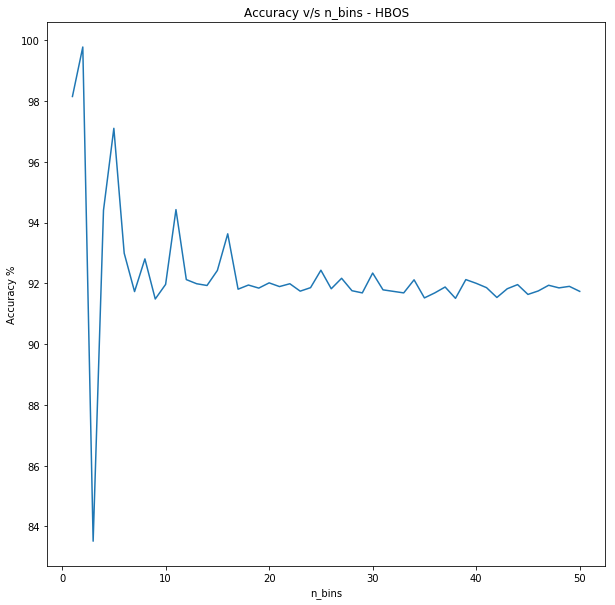

In [23]:
apply_HBOS(X_train, X_test, y_train, y_test)

In [31]:
def roc_HBOS(X_train, X_test, y_train, y_test, bins = 20):
    clf = HBOS(n_bins = bins)
    clf.fit(X_train)
    #get probability scores
    y_scores = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_scores[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    #plot
#     plt.figure(figsize = (10,10))
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.title('ROC Curve of HBOS')
#     plt.show()
    
    n_errors = np.count_nonzero(y_pred != y_test)
#     print(n_errors)
    

#     print("Accuracy (n_bins = 20): " , metrics.accuracy_score(y_test, y_pred))
#     print("Confusion Matrix: ")
    print(metrics.confusion_matrix(y_pred, y_test))
#     print("AUC : ", roc_auc)

In [32]:
roc_HBOS(X_train, X_test, y_train, y_test)

[[12537     9]
 [ 1149   244]]


In [28]:
print(metrics.confusion_matrix(y_pred, y_test))

NameError: name 'y_pred' is not defined

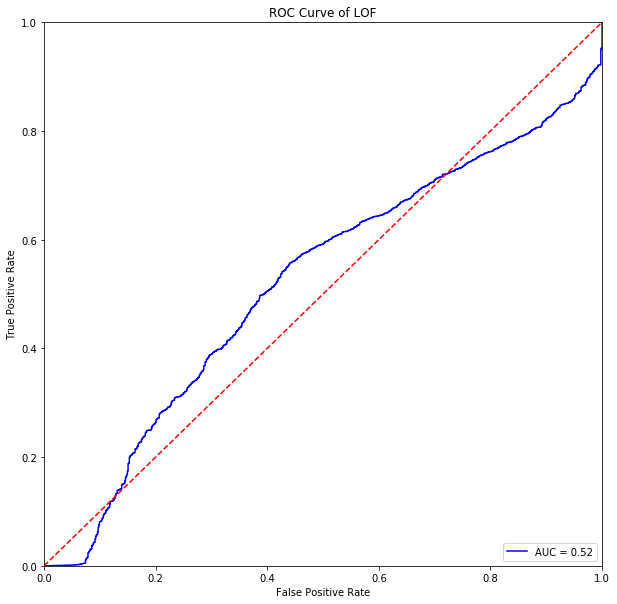

[0 0 0 ... 0 0 0]


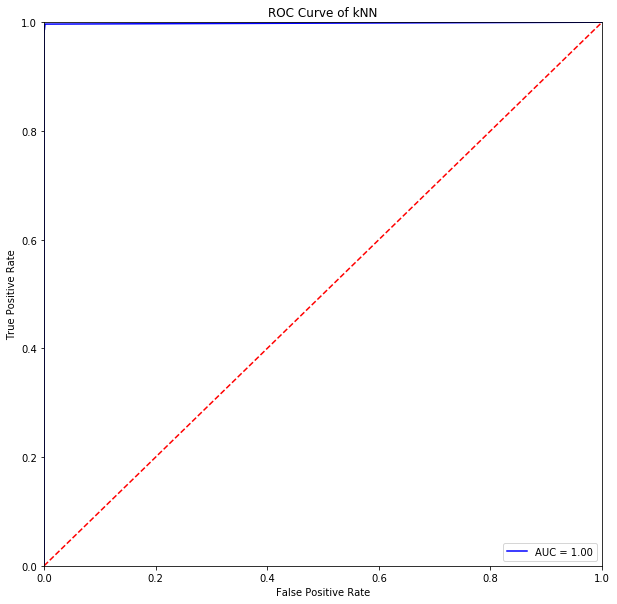

In [80]:
plt.figure(figsize = (12,12))
roc_lof(X, y)
roc_KNN(X_train, X_test, y_train, y_test)

In [26]:
def roc_HBOS1(X_train, X_test, y_train, y_test, bins = 20):
    clf = HBOS(n_bins = bins)
    clf.fit(X_train)
    y_scores = clf.predict_proba(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_scores[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC (n_bins = {}) :: {})".format(bins, roc_auc))

In [27]:
roc_HBOS1(X_train, X_test, y_train, y_test)

AUC (n_bins = 20) :: 0.9885012825459855)


In [34]:
clf = HBOS(n_bins = 20)
clf.fit(X_train)
    #get probability scores
y_scores = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
    
fpr, tpr, threshold = metrics.roc_curve(y_test, y_scores[:,1])
roc_auc = metrics.auc(fpr, tpr)
    #plot
#     plt.figure(figsize = (10,10))
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.title('ROC Curve of HBOS')
#     plt.show()
    
n_errors = np.count_nonzero(y_pred != y_test)
#     print(n_errors)
    

#     print("Accuracy (n_bins = 20): " , metrics.accuracy_score(y_test, y_pred))
#     print("Confusion Matrix: ")
print(metrics.confusion_matrix(y_pred, y_test))
#     print("AUC : ", roc_auc)



[[12537     9]
 [ 1149   244]]


In [62]:
prob = clf.predict_proba(X_test)

In [45]:
y_scores = clf.predict_proba(X_test)
y_scores[:, 1]

huh = pd.DataFrame(y_test, y_scores)

ValueError: Index data must be 1-dimensional

In [46]:
data = {'y_test': y_test, 'prob': y_scores[:,1]}

In [51]:
huh = pd.DataFrame.from_dict(data)

In [52]:
huh.reset_index(drop = True, inplace = True)

In [53]:
huh

,y_test,prob
0,0,0.118588
1,0,0.414026
2,0,0.157460
3,0,0.327459
4,0,0.078881
...,...,...
13934,0,0.380668
13935,0,0.138814
13936,0,0.040403
13937,0,0.369228


In [61]:
huh.sort_values('prob')

,y_test,prob
5254,0,0.000000
11003,0,0.000000
2732,0,0.000000
2730,0,0.000000
13003,0,0.000000
...,...,...
13511,1,0.850953
13717,1,0.850953
7744,1,0.850953
1319,1,0.854110


In [63]:
y_test_roc = np.where(y_test == 1, -1, 1)
y_train_list_roc = []
for i in y_train:
    y_train_list_roc.append(i)
j=0
X_train_list_roc = []
for i in X_train:
    m = []
    m = i.tolist()
    m.append(y_train_list_roc[j])
    X_train_list_roc.append(m)
    j = j+1
df_rejoined_roc = pd.DataFrame(X_train_list_roc)
#     # df_rejoined[30].value_counts()
df_rejoined_inliers_roc = df_rejoined_roc.loc[df_rejoined_roc.iloc[:,-1] == 0]
# #     df_rejoined_inliers
# #     X_train_inliers = df_rejoined_inliers.iloc[:, 0:-1].to_numpy()
X_train_inliers_roc = df_rejoined_inliers_roc.iloc[:, 0:-1].values.astype(float)
# #     X_train_inliers
clf = LocalOutlierFactor(n_neighbors = 20, novelty = True, contamination = 'auto')
clf.fit(X_train_inliers_roc)
#     clf.fit(X_train)
y_proba = clf.decision_function(X_test)
    

In [77]:
data2 = {'y_test': y_test_roc, 'dec_fn_val': y_proba}

In [78]:
phew = pd.DataFrame.from_dict(data2)

In [79]:
phew

,y_test,dec_fn_val
0,1,0.488611
1,1,0.484949
2,1,0.484207
3,1,0.460547
4,1,0.534729
...,...,...
13934,1,-0.831885
13935,1,0.451230
13936,1,0.472221
13937,1,0.498333


In [80]:
phew.reset_index(drop = True, inplace = True)

In [82]:
phew.sort_values('dec_fn_val')

,y_test,dec_fn_val
443,-1,-294.726305
1518,1,-97.267580
7655,-1,-63.367896
2284,-1,-62.350334
802,-1,-61.571899
...,...,...
13789,1,0.579746
1944,1,0.581997
488,1,0.583779
6931,1,0.584820
